In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
! ls "/content/drive/My Drive/dataset"

test  train  validation


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import itertools
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
plt.ion()

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
directory = '/content/drive/My Drive/dataset'
i_dataset = {x: datasets.ImageFolder(os.path.join(directory, x),data_transforms[x])for x in ['train', 'validation', 'test']}

data_load = {x: torch.utils.data.DataLoader(i_dataset[x], batch_size=64, shuffle=True, num_workers=4)
              for x in ['train', 'validation' ,'test']}

data_size = {x: len(i_dataset[x]) for x in ['train', 'validation','test']}

#print({x: len(i_dataset[x]) for x in ['train', 'validation','test']})

class_label = i_dataset['train'].classes
#print(class_label)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
#print(device)

In [0]:
def model_of_training(model, criterion, optimizer, epoch_num):
   
    best_model = copy.deepcopy(model.state_dict())
    train_acc = 0.0
    train_acc_hist = list()
    val_acc = 0.0
    val_acc_hist = list()
    loss_train_hist = list()
    loss_val_hist = list()
    
    for epoch in range(epoch_num):
        for section in ['train', 'validation']:
            if section == 'train':
                model.train()  
            else:
                model.eval()  

            loss_now = 0.0
            correct_out_now = 0
            
            for x, y in data_load[section]:
                x = x.to(device)
                y = y.to(device)
                optimizer.zero_grad()
                
                #forward
                with torch.set_grad_enabled(section == 'train'):
                    out = model(x)
                    _, preds = torch.max(out, 1)
                    loss = criterion(out, y)
                    # Backpropagation and Opitimization Training Section
                    if section == 'train':
                        loss.backward()
                        optimizer.step()

                loss_now += loss.item() * x.size(0)
                correct_out_now += torch.sum(preds == y.data)

            loss_now = loss_now / data_size[section]
            accuracy_epoch = correct_out_now.double() / data_size[section]
            
            if section == 'validation':
                val_acc_hist.append(accuracy_epoch)
                loss_val_hist.append(loss_now)
            else:
                train_acc_hist.append(accuracy_epoch)
                loss_train_hist.append(loss_now)
            
            if section == 'train' and accuracy_epoch > train_acc:
                train_acc = accuracy_epoch
            if section == 'validation' and accuracy_epoch > val_acc:
                val_acc = accuracy_epoch
                
                best_model = copy.deepcopy(model.state_dict())
       

    print('Train Accuracy: {:.2f}'.format(100*train_acc))
    print('Validation Accuracy: {:.2f}'.format(100*val_acc))

    # load best model weights
    model.load_state_dict(best_model)
 
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss")
    #plt.plot(train_acc_hist, color="blue")
    #plt.plot(val_acc_hist, color="yellow")
    plt.plot(loss_train_hist, color="green")
    plt.plot(loss_val_hist, color="red")
    plt.gca().legend(('Train', 'Validation'))
    plt.show()

    return model


In [0]:
def conf_mat_plot(cm, label):
   
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(label))
    plt.xticks(tick_marks, label, rotation=45)
    plt.yticks(tick_marks, label)
    
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),horizontalalignment="center",color="white" if cm[i, j] > threshold else "black")
        
    plt.xlabel('Predicted label')    
    plt.ylabel('True label')
    


In [0]:
def test_acc(trained_model, data_load, data_size):
  
  correct = 0
  top_five = 0
  top_one = 0
  len_test = data_size['test']
  cm = torch.zeros(10, 10)
  np.set_printoptions(precision=2)
  
  with torch.no_grad():
    for i, (x, y) in enumerate(data_load['test']):
        x = x.to(device)
        y = y.to(device)
        out = trained_model(x)
        _, preds = torch.max(out, 1)
        correct  += torch.sum(preds == y.data)
        
        
        for t, p in zip(y.view(-1), preds.view(-1)):
            cm[t.long(), p.long()] += 1
            
            
        probabilities, labels = out.topk(5,dim=1)
        for p in range(labels.size(0)):
          if y[p] in labels[p]:
             top_five +=1
              
        probabilities, labels = out.topk(1,dim=1)
        for p in range(labels.size(0)):
          if y[p] in labels[p]:
             top_one +=1
              
    
    top1_s = 100*top_one / len_test
    top5_s = 100*top_five / len_test
    test_acc =100*correct.double() / len_test
    
    print('Test acc: {:.2f}'.format(test_acc))
    print('Top5 acc: {:.2f}'.format(top5_s))
    print('Top1 acc: {:.2f}'.format(top1_s))
          
  return cm
    

In [0]:
vgg16_model = models.vgg16(pretrained=True)  
#Freeze model weights  
for param in vgg16_model.features.parameters():
    param.requires_grad = False

num_ftrs = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = nn.Linear(num_ftrs ,10)
    
#print(vgg16_model)
vgg16_model  =vgg16_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16_model.parameters(), lr=0.0001)

model_trained = model_of_training(vgg16_model, criterion, optimizer ,epoch_num=10)

matrix = test_acc(vgg16_model,data_load,data_size)

plt.figure(figsize = (10,10))
conf_mat_plot(matrix , label=class_label)
plt.show()


In [21]:
#### PART 3 #############

#delete fc8 layer
model_trained.classifier = nn.Sequential(*list(model_trained.classifier.children())[:-2])
#print(model_trained)


model_trained.eval()
model_trained.to(device)

test_x = []            
test_y =[]
   
tr_x = []
tr_y = []
               
with torch.no_grad():
  
    for i, (x,y) in enumerate(data_load['train']):
        x = x.to(device)
        features1 = model_trained(x)

        tr_y.extend(y.cpu().numpy())
        tr_x.extend(features1.cpu().numpy())
        
    for i, (a,b) in enumerate(data_load['test']):
        a = a.to(device)
        features2 = model_trained(a)

        test_y.extend(b.cpu().numpy())
        test_x.extend(features2.cpu().numpy())

len_test = len(i_dataset["test"].classes) 
correct = np.zeros(len_test)
total = data_size['test']/ len_test

classify = LinearSVC(random_state=0, max_iter=3000)
classifier =classify.fit(tr_x, tr_y)

pred_test =classify.predict(test_x)
for i in range(len(pred_test)):
  if(pred_test[i] == test_y[i]):
    correct[pred_test[i]] = correct[pred_test[i]] + 1

result_acc = 100*classify.score(test_x,test_y)
print('Part 1 Average Accuracy : {:.2f}'.format(result_acc))

for i in range(len(correct)):
  correct[i] = 100* correct[i]/total
  print("{} Class Accuracy = {:.2f}%".format(class_label[i], correct[i]))
  

Part 1 Average Accuracy : 82.40
airport_inside Class Accuracy = 64.00%
bar Class Accuracy = 80.00%
bedroom Class Accuracy = 84.00%
casino Class Accuracy = 92.00%
inside_subway Class Accuracy = 100.00%
kitchen Class Accuracy = 80.00%
livingroom Class Accuracy = 68.00%
restaurant Class Accuracy = 76.00%
subway Class Accuracy = 84.00%
warehouse Class Accuracy = 96.00%


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


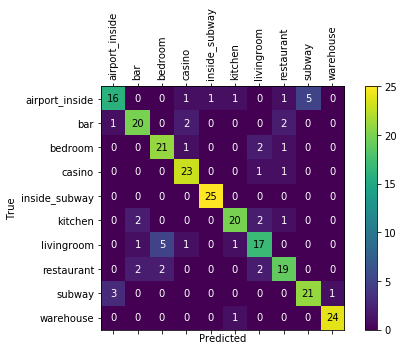

In [22]:
c_m = confusion_matrix(test_y, pred_test)
normalize = False
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(c_m)
fig.colorbar(cax)

fmt = '.2f' if normalize else 'd'
thresh = c_m.max() / 2.
for i in range(c_m.shape[0]):
    for j in range(c_m.shape[1]):
        ax.text(j, i, format(c_m[i, j], fmt),
                ha="center", va="center",
                color="black" if c_m[i, j] > thresh else "white")
fig.tight_layout()

tick_marks = np.arange(len(class_label))
plt.xticks(tick_marks,class_label, rotation=90)
plt.yticks(tick_marks,class_label)    
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()